# Casino Customer Segmentation Model Using Python and Snowflake

## Introduction
This notebook demonstrates the process of building a customer segmentation model for a casino using Python and Snowflake. The segmentation allows the casino to categorize customers based on their behavioral patterns and tailor marketing strategies accordingly.

### Objectives:
- Retrieve customer and transaction data from Snowflake.
- Perform data preprocessing and feature engineering.
- Explore data through visualization.
- Use machine learning to cluster customers into distinct groups.
- Analyze and interpret each customer segment for actionable insights.

## 1. Library Setup and Installation
To start, we need to install and import the necessary Python libraries, including Snowflake connectors for data access and Pandas, Scikit-learn, and Matplotlib for data manipulation, machine learning, and visualization.

### Purpose:
Ensure that all required libraries are installed and configured for data ingestion, processing, and modeling.

## 2. Data Import and Preprocessing
This section involves loading customer and transaction data from the Snowflake database into Pandas DataFrames. After importing, the data undergoes initial cleaning and transformation.

### Key Steps:
- Import customer and transaction data.
- Convert data into Pandas and Snowflake DataFrames.
- Preprocess the data by handling missing values and transforming categorical variables.
- Scale numerical data to ensure consistency across features.

### Outcome:
A clean and preprocessed dataset ready for further analysis.

## 3. Feature Engineering
Feature engineering is used to create additional attributes that provide more insights into customer behavior. These new features help improve the clustering and segmentation process.

### Key Features:
- **Visit Frequency**: How often a customer visits the casino, calculated from the total visits and time span between their first and last visit.
- **Preferred Game**: The game where each customer spends the most time, providing insight into individual preferences.
- **Revenue Metrics**: Total chips won or lost, giving a financial perspective on customer activity.

### Purpose:
Generate new features to better capture customer behavior, enhancing the clustering algorithm's effectiveness.

## 4. Exploratory Data Analysis (EDA) and Visualization
In this step, we use data visualization techniques to explore the relationships between variables and identify patterns in customer behavior. This helps in understanding the data before applying clustering.

### Visualizations:
- **Correlation Matrix**: Shows relationships between numerical features.
- **Distribution Plots**: Visualize the spread of important variables like customer age, revenue, and visit frequency.
- **Histograms**: Display the distribution of key variables and identify outliers.

### Purpose:
EDA helps uncover hidden trends and relationships in the data, guiding further analysis and machine learning tasks.

## 5. Dimensionality Reduction and Clustering
To reduce the complexity of the data, we apply Principal Component Analysis (PCA) and then use clustering algorithms such as K-Means and Agglomerative Clustering to group customers based on their behavior.

### Steps:
- **PCA**: Reduces the number of dimensions, simplifying the dataset while retaining important information.
- **K-Means Clustering**: Groups customers into clusters based on their behavioral patterns.
- **Agglomerative Clustering**: Another clustering technique used to hierarchically group customers.

### Purpose:
Dimensionality reduction makes the dataset easier to visualize, and clustering reveals natural groupings of customers.


## 6. Cluster Profiling
Once clusters are created, we profile each one to understand the characteristics of customers within each group. Profiling helps in labeling the clusters and identifying their unique behaviors.

### Key Metrics:
- **Total Revenue**: How much each cluster contributes to the casino's revenue.
- **Visit Frequency**: The frequency with which customers in each cluster visit the casino.
- **Preferred Games**: Which games are favored by different clusters.

### Visualizations:
- **3D Plot**: Visualizes clusters in a 3D space.
- **Box Plots**: Compare how key metrics like age, revenue, and number of visits vary across clusters.

### Outcome:
Each cluster is assigned meaningful labels based on customer behavior, making it easier to target them with specific marketing strategies.

## 7. Customer Segmentation
Now that we have clustered the customers, we assign descriptive names to the segments to better understand and interpret the groups.

### Example Segments:
- **High Roller Professionals**: Customers who frequently visit and spend large amounts.
- **Conservative Low Spenders**: Customers who visit infrequently and spend minimal amounts.
- **Cross-Spending Players**: Customers who engage in various activities such as gaming, dining, and hotel stays.

### Purpose:
Assign meaningful labels to customer segments to help the casino personalize marketing and engagement strategies.

## 8. Feature Interaction and Exploration
This section explores how key features interact within the different clusters, providing deeper insights into customer behavior.

### Example Interactions:
- **Revenue vs. Visit Frequency**: A scatter plot showing the relationship between visit frequency and total revenue.
- **Age vs. Cluster**: How age influences cluster membership.

### Visualizations:
- **Scatter Plots**: Show how key variables differ across clusters.
- **Box Plots**: Compare the distribution of revenue and other features across clusters.

### Purpose:
Feature interactions provide insights into customer preferences and behaviors, enabling the casino to develop more tailored marketing strategies.

## Summary
In this notebook, we have successfully segmented casino customers into distinct groups based on their behavioral patterns. By analyzing these clusters, the casino can optimize its marketing efforts and offer personalized services to improve customer retention.

### Key Takeaways:
- We identified meaningful customer segments such as high rollers and low spenders.
- Data visualization provided critical insights into customer behavior.
- Clustering allowed us to uncover groups of customers with similar behavioral patterns.
- These results can be used to enhance marketing campaigns and improve customer satisfaction.

This approach provides a strong foundation for developing personalized marketing strategies that increase engagement and drive revenue.


# Setup and Installation of Required Libraries

### In this section, we install and configure all the necessary libraries for connecting to Snowflake, data manipulation, visualization, machine learning, and other utilities. We ensure all packages are up-to-date and compatible with the project requirements.


In [ ]:
# Upgrade pip to the latest version to avoid compatibility issues
!pip install --upgrade pip

# Install Snowflake connectors along with Pandas integration for Snowflake, 
# as well as necessary libraries for data processing and machine learning (e.g., numpy, scikit-learn, xgboost, matplotlib, etc.)
!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 numpy pandas matplotlib scikit-learn xgboost seaborn python-dateutil tqdm holidays faker

# Ensure Snowflake Snowpark Python is upgraded to the desired version (1.9.0)
!pip install --upgrade --q snowflake-snowpark-python==1.9.0

# Uninstalling the current version of urllib3 to avoid version conflicts
!pip uninstall urllib3 -y

# Installing a specific version of urllib3 (1.26.15) known to work with Snowflake and other libraries
!pip install urllib3==1.26.15

# Install fosforml library for machine learning model management and integration
!pip install fosforml==1.1.6

# Install Yellowbrick for machine learning visualization
!pip install yellowbrick


# Importing Required Libraries for Data Processing, Visualization, and Modeling

### In this section, we import various libraries needed for data manipulation, visualization, machine learning, and system utilities. These libraries will help in tasks such as configuring the environment, plotting graphs, managing models, and performing advanced mathematical operations.


In [2]:
# Import all required modules from the fosforml library for model management
from fosforml import *

# Import model flavor constants from fosforml for handling various ML model types
from fosforml.constants import MLModelFlavours

# Importing visualization library (matplotlib) for plotting
from matplotlib import pyplot as plt

# Import essential libraries for data manipulation and numerical operations
import numpy as np
import pandas as pd

# Display a larger number of columns in the DataFrame for better visibility
pd.set_option('display.max_columns', 500)

# Seaborn for statistical data visualization
import seaborn as sns

# Scikit-learn's metric for calculating Mean Absolute Percentage Error (MAPE)
from sklearn.metrics import mean_absolute_percentage_error

# Suppress warnings for cleaner output in the notebook
import warnings; warnings.simplefilter('ignore')

# Joblib for saving and loading ML models efficiently
from joblib import dump, load

# Requests for making HTTP requests to access data from external sources
import requests

# tqdm for progress bars, especially for loops that take a long time to execute
from tqdm import tqdm

# Time utilities for time-based operations
import time
import calendar

# Sleep function to add delays in execution, useful for timing-based operations
from time import sleep

# ConfigParser for reading configuration files
import configparser

# Date manipulation library for working with date ranges, intervals, and easter date calculations
from dateutil.relativedelta import relativedelta
import datetime
from dateutil.easter import easter

# Import functions from scipy for mathematical optimizations and curve fitting
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

# Enable inline plotting for Matplotlib, ensuring plots appear within the notebook
%matplotlib inline


# Configuring Matplotlib and Suppressing Warnings

### This section configures Matplotlib for consistent visualization aesthetics and suppresses warnings to ensure a clean output in the notebook.


In [3]:
# Importing Matplotlib for plotting
import matplotlib.pyplot as plt

# Set Matplotlib's default font family to 'DeJavu Serif' to ensure a consistent font style across plots
plt.rcParams['font.family'] = 'DeJavu Serif'

# Import the warnings library to suppress unnecessary warnings
import warnings

# Suppress all warnings for cleaner notebook output
warnings.filterwarnings("ignore")

# Importing rcParams from Matplotlib for further font configuration
from matplotlib import rcParams

# Configure Matplotlib to use 'DejaVu Sans' font to avoid 'sans-serif' related warnings
rcParams['font.family'] = 'DejaVu Sans'  # or another system-available font


# Importing the Required Libraries for Data Processing, Visualization, and Clustering

### In this section, we import libraries for handling various tasks such as data preprocessing, visualization, and applying machine learning clustering algorithms. Warnings are also suppressed for cleaner outputs.


In [4]:
# Importing datetime to work with date and time objects
import datetime

# Importing Matplotlib and related components for data visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

# Seaborn for statistical data visualizations
import seaborn as sns

# Importing Scikit-learn's preprocessing utilities for encoding categorical variables and scaling numerical data
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# PCA (Principal Component Analysis) for dimensionality reduction
from sklearn.decomposition import PCA

# Yellowbrick's KElbowVisualizer to help determine the optimal number of clusters for KMeans
from yellowbrick.cluster import KElbowVisualizer

# KMeans clustering algorithm from Scikit-learn
from sklearn.cluster import KMeans

# Importing 3D plotting support from Matplotlib for visualizing clusters in 3D space
from mpl_toolkits.mplot3d import Axes3D

# Agglomerative Clustering algorithm for hierarchical clustering
from sklearn.cluster import AgglomerativeClustering

# Importing Matplotlib colormap utilities to handle color mapping for plots
from matplotlib.colors import ListedColormap

# Scikit-learn's metrics module for evaluating clustering performance
from sklearn import metrics

# Importing warnings library to suppress any unnecessary warnings during execution
import warnings

# Import sys to check and apply warnings filter conditions
import sys
if not sys.warnoptions:
    # Suppressing all warnings to clean up output
    warnings.simplefilter("ignore")

# Set a random seed for reproducibility of results
np.random.seed(42)


# Establishing a Snowflake Session for Data Operations

### In this section, we establish a connection to the Snowflake database using the `fosforml` library. This session will be used to execute queries and perform data operations within Snowflake.


In [5]:
# Importing the get_session function from fosforml's Snowflake session manager
from fosforml.model_manager.snowflakesession import get_session

# Establishing a Snowflake session for executing queries and performing operations
my_session = get_session()


# Loading Customer Data into a Pandas DataFrame

### In this section, we load customer data from a CSV file into a Pandas DataFrame. This dataset will be used for further analysis and processing in the notebook.


In [ ]:
# Loading the customer data from a CSV file into a Pandas DataFrame
cust_df = pd.read_csv('customer_table.csv')

# Display the first few rows of the DataFrame to inspect the loaded data
cust_df


# Loading Transaction Data from CSV Files

### Transaction data from multiple CSV files is loaded into separate Pandas DataFrames. These datasets will be merged for further analysis.


In [ ]:
# Load transaction data from multiple CSV files into separate DataFrames
t1_df = pd.read_csv('trx_1.csv')  # First transaction dataset
t2_df = pd.read_csv('trx_2.csv')  # Second transaction dataset
t3_df = pd.read_csv('trx_3.csv')  # Third transaction dataset


# Writing Customer Data to Snowflake Table

### The customer data is converted from a Pandas DataFrame into a Snowflake DataFrame and written to a Snowflake table named `casino_customers`. The `overwrite` mode ensures that the table is replaced if it already exists.


In [ ]:
# Convert the Pandas DataFrame (cust_df) into a Snowflake DataFrame
cust_sfdf = my_session.createDataFrame(cust_df)

# Write the Snowflake DataFrame to a Snowflake table named 'casino_customers'
# The 'overwrite' mode ensures that the table is replaced if it already exists
cust_sfdf.write.mode("overwrite").save_as_table("casino_customers")


# Merging Transaction Data into a Single DataFrame

### The transaction data from multiple DataFrames is merged into a single DataFrame. This combined dataset will be used for further analysis. The `ignore_index=True` ensures that the index is reset after merging.


In [ ]:
# Merge the first two transaction DataFrames (t1_df and t2_df) into one DataFrame
inter_df = t1_df._append(t2_df, ignore_index=True)

# Append the third transaction DataFrame (t3_df) to the intermediate DataFrame
trx_df = inter_df._append(t3_df, ignore_index=True)

# Display the structure and details of the combined transaction DataFrame
trx_df.info()


# Writing Merged Transaction Data to Snowflake Table

### The merged transaction data is converted into a Snowflake DataFrame and written to a Snowflake table named `casino_transactions`. The `overwrite` mode ensures that the table is replaced if it already exists.


In [6]:
# Convert the merged Pandas DataFrame (trx_df) into a Snowflake DataFrame
trx_sfdf = my_session.createDataFrame(trx_df)

# Write the Snowflake DataFrame to a Snowflake table named 'casino_transactions'
# The 'overwrite' mode ensures that the table is replaced if it already exists
trx_sfdf.write.mode("overwrite").save_as_table("casino_transactions")


NameError: name 'trx_df' is not defined

# Querying Data from Snowflake and Converting to Pandas DataFrame

### This section retrieves all records from the `CASINO_TRANSACTIONS` table in Snowflake and converts the resulting Snowflake DataFrame into a Pandas DataFrame for local analysis.


In [8]:
# Define the name of the Snowflake table to query
table_name = 'CASINO_TRANSACTIONS'

# Execute a SQL query to select all records from the specified table in Snowflake
transaction_df = my_session.sql("select * from {}".format(table_name))

# Convert the Snowflake DataFrame to a Pandas DataFrame for further processing
transaction_df = transaction_df.to_pandas()

# Check the type of the resulting DataFrame to confirm it is a Pandas DataFrame
type(transaction_df)


#transaction_df = trx_df.copy()
transaction_df.columns = [col.upper() for col in transaction_df.columns]




In [9]:
customer_aggregation = transaction_df.groupby('PLAYER_ID').agg(
    DATE_FIRST_VISIT=('DATE', 'min'),
    DATE_LAST_VISIT= ('DATE', 'max'),
    TOTAL_NUMBER_OF_VISITS=('TRANSACTION_ID', 'count'),
    TOTAL_DURATION_SPENT=('DURATION_SPENT', 'sum'),
    AVERAGE_DURATION_PER_VISIT=('DURATION_SPENT', 'mean'),
    TOTAL_CHIPS_WON_OR_LOST=('CHIPS_WON_OR_LOST', 'sum'),
    AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT=('CHIPS_WON_OR_LOST', 'mean'),
    UNIQUE_GAMES_PLAYED=('GAME_NAME', 'nunique'),
    IS_PREMIUM_PLAYER=('IS_PREMIUM_PLAYER', 'max'),
    IS_LOYALTY_CARD_HOLDER=('IS_LOYALTY_CARD_HOLDER', 'max'),
    TOTAL_AMOUNT_SPENT_IN_HOTEL=('AMOUNT_SPENT_IN_HOTEL_STAY', 'sum'),
    TOTAL_DAYS_SPENT_HOTEL=('NUMBER_OF_DAYS_SPENT_IN_HOTEL', 'sum'),
    TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT=('AMOUNT_SPENT_IN_CASINO_RESTAURANT', 'sum'),
    NUMBER_OF_RESTAURANT_VISITS=('NUMBER_OF_RESTAURANT_VISITS', 'sum'),
    TOTAL_AMOUNT_SPENT_IN_SPA=('AMOUNT_SPENT_IN_SPA', 'sum'),
    NUMBER_OF_SPA_VISITS=('NUMBER_OF_SPA_VISITS', 'sum'),
    TOTAL_REVENUE_TO_CASINO=('REVENUE_MADE_BY_CASINO_FROM_PLAYER', 'sum'),
    NUMBER_OF_CONCIERGE_VISITS=('NUMBER_OF_CONCIERGE_VISITS', 'sum')
).reset_index()

In [10]:
customer_aggregation['DATE_FIRST_VISIT'] = pd.to_datetime(customer_aggregation['DATE_FIRST_VISIT'], format = 'mixed')
customer_aggregation['DATE_LAST_VISIT'] = pd.to_datetime(customer_aggregation['DATE_LAST_VISIT'], format = 'mixed')
transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'], format = 'mixed')

In [11]:
customer_aggregation.head()

,PLAYER_ID,DATE_FIRST_VISIT,DATE_LAST_VISIT,TOTAL_NUMBER_OF_VISITS,TOTAL_DURATION_SPENT,AVERAGE_DURATION_PER_VISIT,TOTAL_CHIPS_WON_OR_LOST,AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT,UNIQUE_GAMES_PLAYED,IS_PREMIUM_PLAYER,IS_LOYALTY_CARD_HOLDER,TOTAL_AMOUNT_SPENT_IN_HOTEL,TOTAL_DAYS_SPENT_HOTEL,TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT,NUMBER_OF_RESTAURANT_VISITS,TOTAL_AMOUNT_SPENT_IN_SPA,NUMBER_OF_SPA_VISITS,TOTAL_REVENUE_TO_CASINO,NUMBER_OF_CONCIERGE_VISITS
0,1,2024-02-03,2023-01-28,16,73.01,4.563125,-665,-41.562500,8,True,True,16761.63,168,4641.46,88,6740.90,30,28808.99,70
1,2,2022-01-10,2023-03-31,17,75.23,4.425294,-575,-33.823529,7,True,False,17606.60,102,4329.05,93,8150.97,32,30661.62,74
2,3,2023-01-10,2022-08-31,18,89.00,4.944444,1052,58.444444,9,False,True,29230.19,186,4920.18,87,9956.91,32,43055.28,64
3,4,2021-01-10,2023-12-29,25,98.67,3.946800,2910,116.400000,9,True,False,34051.70,172,6511.57,119,14235.40,42,51888.67,94
4,5,2023-04-01,2022-07-29,21,90.36,4.302857,878,41.809524,10,True,False,25572.89,124,5895.50,80,9832.29,43,40422.68,67


In [12]:
customer_aggregation[customer_aggregation['DATE_FIRST_VISIT']<customer_aggregation['DATE_LAST_VISIT']]

,PLAYER_ID,DATE_FIRST_VISIT,DATE_LAST_VISIT,TOTAL_NUMBER_OF_VISITS,TOTAL_DURATION_SPENT,AVERAGE_DURATION_PER_VISIT,TOTAL_CHIPS_WON_OR_LOST,AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT,UNIQUE_GAMES_PLAYED,IS_PREMIUM_PLAYER,IS_LOYALTY_CARD_HOLDER,TOTAL_AMOUNT_SPENT_IN_HOTEL,TOTAL_DAYS_SPENT_HOTEL,TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT,NUMBER_OF_RESTAURANT_VISITS,TOTAL_AMOUNT_SPENT_IN_SPA,NUMBER_OF_SPA_VISITS,TOTAL_REVENUE_TO_CASINO,NUMBER_OF_CONCIERGE_VISITS
1,2,2022-01-10,2023-03-31,17,75.23,4.425294,-575,-33.823529,7,True,False,17606.60,102,4329.05,93,8150.97,32,30661.62,74
3,4,2021-01-10,2023-12-29,25,98.67,3.946800,2910,116.400000,9,True,False,34051.70,172,6511.57,119,14235.40,42,51888.67,94
5,6,2022-03-06,2023-12-31,28,122.34,4.369286,-3168,-113.142857,10,False,True,44499.61,157,7829.84,115,14644.00,49,70141.45,108
6,7,2021-03-11,2023-12-26,19,70.37,3.703684,6110,321.578947,10,False,False,17941.11,60,4159.12,83,10700.75,49,26690.98,72
8,9,2023-01-06,2024-01-31,26,122.77,4.721923,-1707,-65.653846,11,False,False,35188.18,222,7075.76,131,14924.54,49,58895.48,118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,9995,2022-03-04,2022-10-29,14,64.50,4.607143,-4095,-292.500000,7,False,False,23903.80,88,4735.49,49,6637.86,29,39372.15,81
9995,9996,2024-01-02,2024-01-30,28,136.92,4.890000,-5428,-193.857143,9,False,False,31867.03,194,7698.43,89,15559.75,58,60553.21,136
9996,9997,2022-03-10,2022-08-28,15,76.55,5.103333,-123,-8.200000,8,False,False,13506.26,74,3514.64,67,8633.49,37,25777.39,80
9997,9998,2022-01-03,2022-10-31,20,90.47,4.523500,3721,186.050000,9,False,False,32470.08,152,6080.56,101,11276.78,40,46106.42,87


In [13]:
# Calculating preferred game category and name
preferred_game = transaction_df.groupby(['PLAYER_ID', 'GAME_CATEGORY', 'GAME_NAME','PLAYER_AGE', 'PLAYER_GENDER', 'HOME_COUNTRY', 'HOME_CITY'])['DURATION_SPENT'].sum().reset_index()
preferred_game = preferred_game.loc[preferred_game.groupby('PLAYER_ID')['DURATION_SPENT'].idxmax()][['PLAYER_ID', 'GAME_CATEGORY', 'GAME_NAME', 'PLAYER_AGE', 'PLAYER_GENDER', 'HOME_COUNTRY', 'HOME_CITY']]
preferred_game


,PLAYER_ID,GAME_CATEGORY,GAME_NAME,PLAYER_AGE,PLAYER_GENDER,HOME_COUNTRY,HOME_CITY
1,1,Slot games,Video Slots,28,Female,India,Hyderabad
11,2,Speciality Number Games,Bingo,69,Female,Singapore,Singapore
17,3,Slot games,Video Slots,52,Female,Singapore,Singapore
28,4,Speciality Number Games,Keno,41,Female,India,Delhi
34,5,Slot games,Classic Slots,66,Female,UK,Manchester
...,...,...,...,...,...,...,...
90189,9996,Slot games,3D Slots,29,Male,Singapore,Singapore
90198,9997,Slot games,3D Slots,47,Female,Singapore,Singapore
90210,9998,Speciality Number Games,Keno,55,Female,US,Los Angeles
90216,9999,Slot games,Video Slots,51,Male,US,San Jose


In [14]:
customer_aggregation = customer_aggregation.merge(preferred_game, on='PLAYER_ID', how='left')
customer_aggregation


,PLAYER_ID,DATE_FIRST_VISIT,DATE_LAST_VISIT,TOTAL_NUMBER_OF_VISITS,TOTAL_DURATION_SPENT,AVERAGE_DURATION_PER_VISIT,TOTAL_CHIPS_WON_OR_LOST,AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT,UNIQUE_GAMES_PLAYED,IS_PREMIUM_PLAYER,IS_LOYALTY_CARD_HOLDER,TOTAL_AMOUNT_SPENT_IN_HOTEL,TOTAL_DAYS_SPENT_HOTEL,TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT,NUMBER_OF_RESTAURANT_VISITS,TOTAL_AMOUNT_SPENT_IN_SPA,NUMBER_OF_SPA_VISITS,TOTAL_REVENUE_TO_CASINO,NUMBER_OF_CONCIERGE_VISITS,GAME_CATEGORY,GAME_NAME,PLAYER_AGE,PLAYER_GENDER,HOME_COUNTRY,HOME_CITY
0,1,2024-02-03,2023-01-28,16,73.01,4.563125,-665,-41.562500,8,True,True,16761.63,168,4641.46,88,6740.90,30,28808.99,70,Slot games,Video Slots,28,Female,India,Hyderabad
1,2,2022-01-10,2023-03-31,17,75.23,4.425294,-575,-33.823529,7,True,False,17606.60,102,4329.05,93,8150.97,32,30661.62,74,Speciality Number Games,Bingo,69,Female,Singapore,Singapore
2,3,2023-01-10,2022-08-31,18,89.00,4.944444,1052,58.444444,9,False,True,29230.19,186,4920.18,87,9956.91,32,43055.28,64,Slot games,Video Slots,52,Female,Singapore,Singapore
3,4,2021-01-10,2023-12-29,25,98.67,3.946800,2910,116.400000,9,True,False,34051.70,172,6511.57,119,14235.40,42,51888.67,94,Speciality Number Games,Keno,41,Female,India,Delhi
4,5,2023-04-01,2022-07-29,21,90.36,4.302857,878,41.809524,10,True,False,25572.89,124,5895.50,80,9832.29,43,40422.68,67,Slot games,Classic Slots,66,Female,UK,Manchester
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,2024-01-02,2024-01-30,28,136.92,4.890000,-5428,-193.857143,9,False,False,31867.03,194,7698.43,89,15559.75,58,60553.21,136,Slot games,3D Slots,29,Male,Singapore,Singapore
9996,9997,2022-03-10,2022-08-28,15,76.55,5.103333,-123,-8.200000,8,False,False,13506.26,74,3514.64,67,8633.49,37,25777.39,80,Slot games,3D Slots,47,Female,Singapore,Singapore
9997,9998,2022-01-03,2022-10-31,20,90.47,4.523500,3721,186.050000,9,False,False,32470.08,152,6080.56,101,11276.78,40,46106.42,87,Speciality Number Games,Keno,55,Female,US,Los Angeles
9998,9999,2022-01-05,2023-11-30,19,89.67,4.719474,889,46.789474,7,False,False,15061.38,134,4301.71,102,10924.60,34,29398.69,72,Slot games,Video Slots,51,Male,US,San Jose


In [15]:
customer_aggregation.rename(columns= {'PLAYER_AGE':'AGE' , 'PLAYER_GENDER':'GENDER', 'GAME_CATEGORY':'PREFERRED_GAME_CATEGORY', 
                                      'GAME_NAME':'PREFERRED_GAME_NAME'}, inplace= True) 
customer_aggregation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   PLAYER_ID                                10000 non-null  int16         
 1   DATE_FIRST_VISIT                         10000 non-null  datetime64[ns]
 2   DATE_LAST_VISIT                          10000 non-null  datetime64[ns]
 3   TOTAL_NUMBER_OF_VISITS                   10000 non-null  int64         
 4   TOTAL_DURATION_SPENT                     10000 non-null  float64       
 5   AVERAGE_DURATION_PER_VISIT               10000 non-null  float64       
 6   TOTAL_CHIPS_WON_OR_LOST                  10000 non-null  int16         
 7   AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT      10000 non-null  float64       
 8   UNIQUE_GAMES_PLAYED                      10000 non-null  int64         
 9   IS_PREMIUM_PLAYER                       

In [16]:
customer_df = customer_aggregation.copy()

# Data Preparation

In [17]:
# Date transformation data type

customer_df['DATE_FIRST_VISIT'] = pd.to_datetime(customer_df['DATE_FIRST_VISIT'], format = 'mixed')
customer_df['DATE_LAST_VISIT'] = pd.to_datetime(customer_df['DATE_LAST_VISIT'], format = 'mixed')
transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'], format = 'mixed')

In [18]:
print(customer_df.info())
print(transaction_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   PLAYER_ID                                10000 non-null  int16         
 1   DATE_FIRST_VISIT                         10000 non-null  datetime64[ns]
 2   DATE_LAST_VISIT                          10000 non-null  datetime64[ns]
 3   TOTAL_NUMBER_OF_VISITS                   10000 non-null  int64         
 4   TOTAL_DURATION_SPENT                     10000 non-null  float64       
 5   AVERAGE_DURATION_PER_VISIT               10000 non-null  float64       
 6   TOTAL_CHIPS_WON_OR_LOST                  10000 non-null  int16         
 7   AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT      10000 non-null  float64       
 8   UNIQUE_GAMES_PLAYED                      10000 non-null  int64         
 9   IS_PREMIUM_PLAYER                       

In [19]:
# Adding new features for better classification
customer_df['VISIT_FREQUENCY'] = customer_df['TOTAL_NUMBER_OF_VISITS'] / ((pd.to_datetime(customer_df['DATE_LAST_VISIT']) - 
                                                                           pd.to_datetime(customer_df['DATE_FIRST_VISIT'])).dt.days + 1)

In [20]:
#Get list of categorical variables
s = (customer_df.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['PREFERRED_GAME_CATEGORY', 'PREFERRED_GAME_NAME', 'GENDER', 'HOME_COUNTRY', 'HOME_CITY']


In [21]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    customer_df[i]=customer_df[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [22]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   PLAYER_ID                                10000 non-null  int16         
 1   DATE_FIRST_VISIT                         10000 non-null  datetime64[ns]
 2   DATE_LAST_VISIT                          10000 non-null  datetime64[ns]
 3   TOTAL_NUMBER_OF_VISITS                   10000 non-null  int64         
 4   TOTAL_DURATION_SPENT                     10000 non-null  float64       
 5   AVERAGE_DURATION_PER_VISIT               10000 non-null  float64       
 6   TOTAL_CHIPS_WON_OR_LOST                  10000 non-null  int16         
 7   AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT      10000 non-null  float64       
 8   UNIQUE_GAMES_PLAYED                      10000 non-null  int64         
 9   IS_PREMIUM_PLAYER                       

In [23]:
print(customer_df.max(axis=0)) # will return max value of each column
print(customer_df.min(axis=0)) # will return min value of each column

PLAYER_ID                                                10000
DATE_FIRST_VISIT                           2024-12-05 00:00:00
DATE_LAST_VISIT                            2024-08-31 00:00:00
TOTAL_NUMBER_OF_VISITS                                      38
TOTAL_DURATION_SPENT                                    176.18
AVERAGE_DURATION_PER_VISIT                            6.264615
TOTAL_CHIPS_WON_OR_LOST                                   9526
AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT                 503.642857
UNIQUE_GAMES_PLAYED                                         11
IS_PREMIUM_PLAYER                                         True
IS_LOYALTY_CARD_HOLDER                                    True
TOTAL_AMOUNT_SPENT_IN_HOTEL                           68940.17
TOTAL_DAYS_SPENT_HOTEL                                     377
TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT               10916.06
NUMBER_OF_RESTAURANT_VISITS                                204
TOTAL_AMOUNT_SPENT_IN_SPA                             2

In [26]:
print(customer_df.mean(axis=0)) # will return min value of each column

PLAYER_ID                                                         5000.5
DATE_FIRST_VISIT                              2022-11-01 10:59:39.840000
DATE_LAST_VISIT                            2023-03-19 01:54:37.439999744
TOTAL_NUMBER_OF_VISITS                                              20.0
TOTAL_DURATION_SPENT                                           90.132173
AVERAGE_DURATION_PER_VISIT                                      4.506848
TOTAL_CHIPS_WON_OR_LOST                                          -3.9898
AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT                             0.026963
UNIQUE_GAMES_PLAYED                                               9.0232
IS_PREMIUM_PLAYER                                                 0.2513
IS_LOYALTY_CARD_HOLDER                                            0.2466
TOTAL_AMOUNT_SPENT_IN_HOTEL                                  25496.13566
TOTAL_DAYS_SPENT_HOTEL                                          150.0237
TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT            

In [ ]:
# sf_df = my_session.createDataFrame(customer_df)
# sf_df.write.mode("overwrite").save_as_table("CASINO_CUSTOMERS")
# my_session.table("CASINO_CUSTOMERS").show()

In [ ]:
customer_df.head()

In [28]:
# Creating a copy of data
ds = customer_df.copy()

# Creating a subset of dataframe by dropping certain columns
cols_del = ['DATE_FIRST_VISIT', 'DATE_LAST_VISIT']
ds = ds.drop(cols_del, axis=1)

# Check for NaN, inf, or -inf in the dataset
print(f"NaN values in the dataset:\n{ds.isna().sum()}")
print(f"Any inf or -inf in the dataset:\n{(ds == np.inf).sum() + (ds == -np.inf).sum()}")

# Option 1: Replace inf, -inf, and NaN with a specified value (e.g., mean, median, or 0)
ds = ds.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
ds.fillna(ds.mean(), inplace=True)  # Replace NaN with mean of each column

# Option 2: Alternatively, you can drop rows containing these values
# ds = ds.replace([np.inf, -np.inf], np.nan).dropna()

# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds), columns=ds.columns)

print("All features are now scaled")


NaN values in the dataset:
PLAYER_ID                                  0
TOTAL_NUMBER_OF_VISITS                     0
TOTAL_DURATION_SPENT                       0
AVERAGE_DURATION_PER_VISIT                 0
TOTAL_CHIPS_WON_OR_LOST                    0
AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT        0
UNIQUE_GAMES_PLAYED                        0
IS_PREMIUM_PLAYER                          0
IS_LOYALTY_CARD_HOLDER                     0
TOTAL_AMOUNT_SPENT_IN_HOTEL                0
TOTAL_DAYS_SPENT_HOTEL                     0
TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT    0
NUMBER_OF_RESTAURANT_VISITS                0
TOTAL_AMOUNT_SPENT_IN_SPA                  0
NUMBER_OF_SPA_VISITS                       0
TOTAL_REVENUE_TO_CASINO                    0
NUMBER_OF_CONCIERGE_VISITS                 0
PREFERRED_GAME_CATEGORY                    0
PREFERRED_GAME_NAME                        0
AGE                                        0
GENDER                                     0
HOME_COUNTRY                

In [ ]:
ds.info()

# Data Exploration

In [29]:
# Descriptive statistics for customer data
print(customer_df.describe(include='all'))
print(transaction_df.describe(include='all'))

          PLAYER_ID            DATE_FIRST_VISIT  \
count   10000.00000                       10000   
unique          NaN                         NaN   
top             NaN                         NaN   
freq            NaN                         NaN   
mean     5000.50000  2022-11-01 10:59:39.840000   
min         1.00000         2021-01-09 00:00:00   
25%      2500.75000         2022-01-27 00:00:00   
50%      5000.50000         2023-01-05 00:00:00   
75%      7500.25000         2023-07-03 06:00:00   
max     10000.00000         2024-12-05 00:00:00   
std      2886.89568                         NaN   

                      DATE_LAST_VISIT  TOTAL_NUMBER_OF_VISITS  \
count                           10000            10000.000000   
unique                            NaN                     NaN   
top                               NaN                     NaN   
freq                              NaN                     NaN   
mean    2023-03-19 01:54:37.439999744               20.000000 

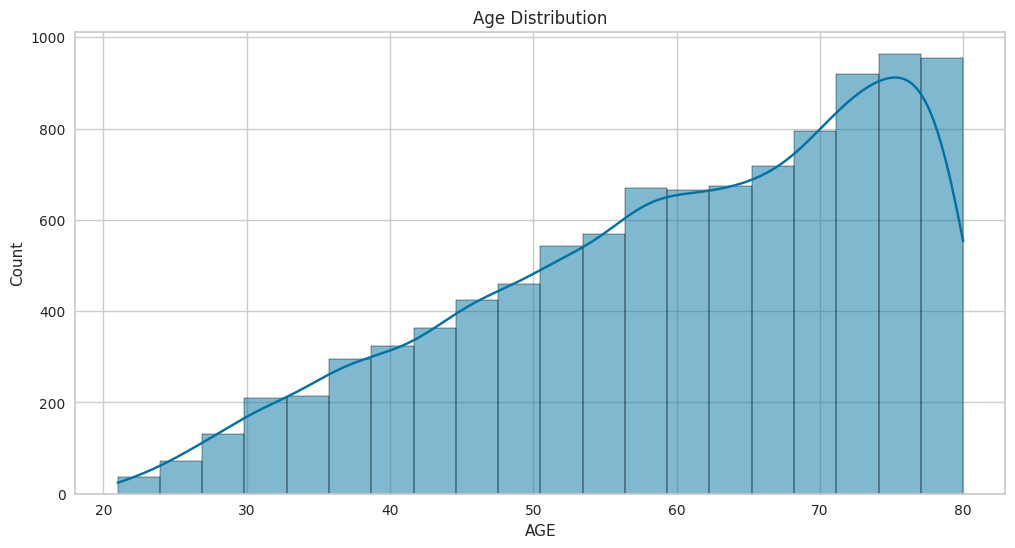

In [30]:
# Plotting distribution of age
from matplotlib import rcParams

# Configure the font family to avoid 'sans-serif' warnings
rcParams['font.family'] = 'DejaVu Sans'  # or another available font on your system

plt.figure(figsize=(12, 6))
sns.histplot(customer_df['AGE'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

In [31]:
# Checking for missing values
print(customer_df.isna().sum())

PLAYER_ID                                  0
DATE_FIRST_VISIT                           0
DATE_LAST_VISIT                            0
TOTAL_NUMBER_OF_VISITS                     0
TOTAL_DURATION_SPENT                       0
AVERAGE_DURATION_PER_VISIT                 0
TOTAL_CHIPS_WON_OR_LOST                    0
AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT        0
UNIQUE_GAMES_PLAYED                        0
IS_PREMIUM_PLAYER                          0
IS_LOYALTY_CARD_HOLDER                     0
TOTAL_AMOUNT_SPENT_IN_HOTEL                0
TOTAL_DAYS_SPENT_HOTEL                     0
TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT    0
NUMBER_OF_RESTAURANT_VISITS                0
TOTAL_AMOUNT_SPENT_IN_SPA                  0
NUMBER_OF_SPA_VISITS                       0
TOTAL_REVENUE_TO_CASINO                    0
NUMBER_OF_CONCIERGE_VISITS                 0
PREFERRED_GAME_CATEGORY                    0
PREFERRED_GAME_NAME                        0
AGE                                        0
GENDER    

In [32]:
# Fill missing values or drop them if appropriate
customer_df = customer_df.dropna()  # Here we simply drop missing values

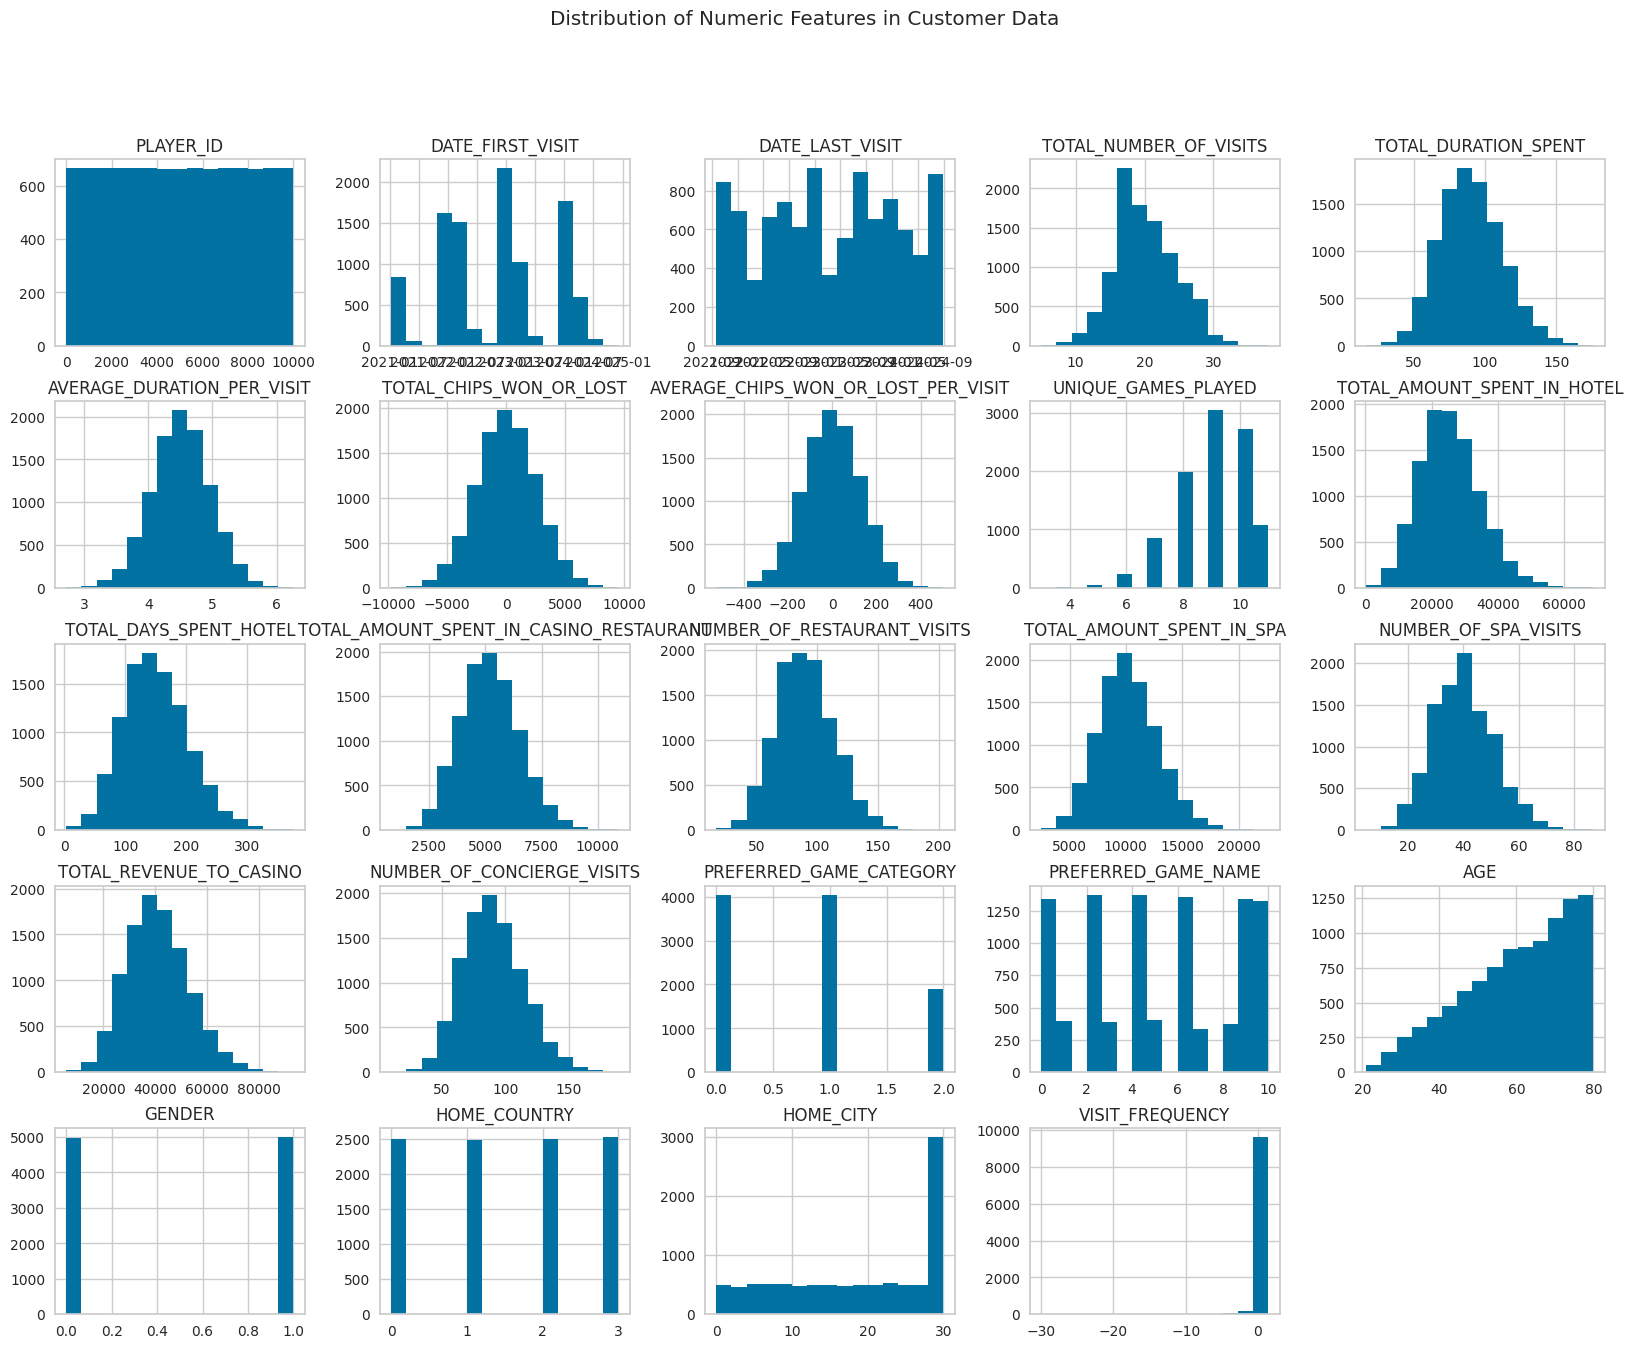

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Creating a copy of the dataset
ds = customer_df.copy()

# Check for and handle 'inf' or '-inf' values
ds.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Drop rows containing NaN values
ds.dropna(inplace=True)

# Option 2: Alternatively, you can fill NaN values with the mean or median
# ds.fillna(ds.mean(), inplace=True)

# Plotting distribution for numeric features in the customer data
ds.hist(bins=15, figsize=(20, 15))
plt.suptitle('Distribution of Numeric Features in Customer Data')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix for customer_df
correlation_matrix = customer_df.corr()

# Set the figure size larger
plt.figure(figsize=(25, 20))

# Create the heatmap with larger annotations
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    annot_kws={"size": 12},  # Increase the annotation font size
    linewidths=0.5,          # Add spacing between cells for better readability
    linecolor='gray'         # Add lines to separate cells
)

# Add title and display
plt.title('Correlation Matrix for Customer Data', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


In [ ]:
corrmat= customer_df.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap='coolwarm', center=0)

In [ ]:
scaled_ds.head()

In [ ]:
customer_df.info()

In [ ]:
# Plotting categorical features against target variable
sns.countplot(x='GENDER', data=customer_df)
plt.title('Gender Distribution')
plt.show()

In [ ]:
sns.countplot(x='HOME_COUNTRY', data=customer_df)
plt.title('Country Distribution')
plt.show()

# PCA: Principal component analysis

In [ ]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

In [ ]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="blue", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# Clustering

In [ ]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [ ]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(scaled_ds)
Elbow_M.show()

In [ ]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)

# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["CLUSTERS"] = yhat_AC

#Adding the Clusters feature to the orignal dataframe.
customer_df["CLUSTERS"]= yhat_AC

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Plotting the clusters
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d')

# Use a valid colormap like 'viridis'
ax.scatter(x, y, z, s=40, c=PCA_ds["CLUSTERS"], marker='o', cmap='viridis')

# Set the title
ax.set_title("The Plot Of The Clusters")

# Show the plot
plt.show()


# Model Evaluation

In [ ]:
#Plotting countplot of clusters
pal = ["#FF5733","#33FF57", "#3357FF","#FF33A1",] #"#FFD700"]
pl = sns.countplot(x=customer_df["CLUSTERS"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

In [ ]:
pl = sns.scatterplot(data = customer_df,x=customer_df["TOTAL_REVENUE_TO_CASINO"], y=customer_df["VISIT_FREQUENCY"],hue=customer_df["CLUSTERS"], palette= pal)
pl.set_title("Cluster's Profile Based On revenue to Casino")
plt.legend()
plt.show()

In [ ]:
plt.figure()
pl=sns.swarmplot(x=customer_df["CLUSTERS"], y=customer_df["TOTAL_REVENUE_TO_CASINO"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=customer_df["CLUSTERS"], y=customer_df["TOTAL_REVENUE_TO_CASINO"], palette=pal)
plt.show()

In [ ]:
plt.figure()
pl=sns.swarmplot(x=customer_df["CLUSTERS"], y=customer_df["TOTAL_NUMBER_OF_VISITS"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=customer_df["CLUSTERS"], y=customer_df["TOTAL_NUMBER_OF_VISITS"], palette=pal)
plt.show()

In [ ]:
#Plotting
plt.figure()
pl=sns.boxenplot(y=customer_df["TOTAL_CHIPS_WON_OR_LOST"],x=customer_df["CLUSTERS"], palette= pal)
pl.set_title("TOTAL_CHIPS_WON_OR_LOST")
plt.show()

# PROFILING

In [ ]:
column_list = [ "AGE", "GENDER","HOME_COUNTRY","TOTAL_DURATION_SPENT","TOTAL_CHIPS_WON_OR_LOST","AVERAGE_DURATION_PER_VISIT",
               "AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT", "UNIQUE_GAMES_PLAYED", 
               "IS_PREMIUM_PLAYER", "IS_LOYALTY_CARD_HOLDER", "TOTAL_AMOUNT_SPENT_IN_HOTEL", "TOTAL_DAYS_SPENT_HOTEL",
               "TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT","NUMBER_OF_RESTAURANT_VISITS", "TOTAL_AMOUNT_SPENT_IN_SPA", "NUMBER_OF_SPA_VISITS",
               "TOTAL_REVENUE_TO_CASINO", "NUMBER_OF_CONCIERGE_VISITS", "VISIT_FREQUENCY"]

for i in column_list:
    plt.figure()
    sns.jointplot(x=customer_df[i], y=customer_df["TOTAL_REVENUE_TO_CASINO"], hue =customer_df["CLUSTERS"], kind="kde", palette=pal)
    plt.show()

In [ ]:
segment_mapping = {
    0: 'High roller Professionals',
    1: 'Conservative Low spenders',
    2: 'Mediocre cross spending players',
    3: 'Money losing players'
}

# Use the map function to assign player segments based on the cluster labels
customer_df['PLAYER_SEGMENT'] = customer_df['CLUSTERS'].map(segment_mapping)
customer_df['PLAYER_SEGMENT']

# Assigning Detailed Segment Descriptions Based on Cluster Labels

### A more efficient approach to assigning detailed descriptions to each customer segment based on cluster membership using a dictionary mapping. This method improves code readability and performance.


In [ ]:
segment_desc_mapping = {
    0: 'Risk taking professional, regular players with deep pockets spending across services',
    1: 'Low spends, low money making low risk players',
    2: 'Budding good Players with potential to win, exploring multiple casino services',
    3: 'Money losing players'
}

# Use the map function to assign segment descriptions based on the cluster labels
customer_df['SEGMENT_DESC'] = customer_df['CLUSTERS'].map(segment_desc_mapping)
customer_df['SEGMENT_DESC']

In [ ]:
my_session.table(['CUSTOMER_SEGMENTS_LATEST']).to_pandas().to_csv('CUSTOMER_SEGMENTS_LATEST.csv', index=False)